# "A data-driven biology-based network model reproduces C. elegans premotor neural dynamics" figure bookmarks


### [Results -> Analysis -> Ablation of core neurons -> Figure 6](#Figure-6)

Go to [load processed White graph data](#White_graph_data)

Go to [Find highly correlated neurons](#Find_highly_correlated_neurons)

Go to [Simulation setup data](#simulation_setup_data)

Go to [ODE simulation](#ODE_simulation)

### Run many simulations and compute higher order stats, test with and without EJ and Syn

In [1]:

curdir = pwd()
dir_one_up = abspath(joinpath(curdir, ".."))

# using Pkg
# Pkg.update()

"/Users/mmtre/Library/CloudStorage/OneDrive-IllinoisInstituteofTechnology/Github repos/Celegans_premotor/"

In [2]:
using LinearAlgebra
using DifferentialEquations
using Statistics
using SparseArrays

using JSON
using SavitzkyGolay
using Plots
using Measures  # <- needed to use mm, cm, px, etc.
using LaTeXStrings

using StatsPlots
using DataInterpolations

using SciMLBase
using OrdinaryDiffEq

using Plots, ImplicitEquations
using ImplicitPlots
using Roots

using NonlinearSolve, SteadyStateDiffEq
using NLsolve

using Random

##########################
### set font defaults ####
##########################
plot_font = "Computer Modern"

default(
    fontfamily=plot_font,
    titlefontsize = 11,
    labelfontsize = 9,
    linewidth=2, 
    framestyle=:nothing, 
    label=nothing, 
    grid=true
)


#####################################
######     Make colors   ############
#####################################
color_array = ["43c7c0","6ed0ca","99d8d4","c4e0de","efe8e7","f3b8b6","f68785","f95754","fc2622"]
# Convert hexadecimal colors to RGB colors
rgb_colors = [parse(RGB, "#" * color) for color in color_array]



clrsp = palette(:batlow10)
clrs = [clrsp[2], clrsp[2], clrsp[2], clrsp[2], clrsp[2], clrsp[5], clrsp[5],
    clrsp[8], clrsp[8], clrsp[8], clrsp[8], clrsp[8], clrsp[8], clrsp[8], clrsp[8]]

clrs_short = [clrsp[2], clrsp[8]]


display(clrsp)
display(rgb_colors)
display(clrs)

grey_colors = ["e5e6e4","e5e5e5", "b1a7a6", "adb5bd", "6c757d"]
rgb_greys = [parse(RGB, "#" * color) for color in grey_colors]

display(rgb_greys)

In [3]:
#################################
#### load saved functions  ######
#################################

filename = "functions_regression.jl"
data_folder = "functions"
filepath = joinpath(joinpath(dir_one_up, data_folder), filename);
include(filepath)

#include("functions/functions_regression.jl")
######### contains functions .. #########
## RELU
## Data_Replacement

filename = "functions_simulation.jl"
filepath = joinpath(joinpath(dir_one_up, data_folder), filename);
include(filepath)

#include("functions/functions_simulation.jl")
######### contains functions .. #########
## lorenz!
## moving_average
## heaviside_pulse


heaviside_pulse (generic function with 1 method)

## White_graph_data



In [4]:
using DataFrames
using CSV

data_folder = "data/White_data_processed"
filename = "df5.csv"
filepath = joinpath(joinpath(dir_one_up, data_folder), filename);
df5 = DataFrame(CSV.File(filepath));

############################################
### take processed data from White #########
############################################

out_set = collect(Set(df5[!, :"Neuron2"]))
in_set = collect(Set(df5[!, :"Neuron1"]))
final_neurons = union(out_set, in_set)
N = size(final_neurons)[1]  ## number of neurons in my model
final_neuron_dict = Dict(zip(final_neurons, collect(1:N)))

#############################
### make EJ matrix ##########
#############################
df_EJ = filter(row -> row."Type" == "EJ",df5) # df_subset
EJ_mat = zeros(N,N)
for i in collect(1:size(df_EJ,1))
    w_tmp = df_EJ[i,:]["Nbr"]
    neuro1 = df_EJ[i,:]["Neuron1"]
    neuro2 = df_EJ[i,:]["Neuron2"]
    id1 = final_neuron_dict[neuro1]
    id2 = final_neuron_dict[neuro2]
    EJ_mat[id1, id2] = w_tmp
end

#############################
### make Syn matrix #########
#############################
df_S = filter(row -> row."Type" == "S",df5) # df_subset
S_mat = zeros(N,N)

for i in collect(1:size(df_S,1))
    w_tmp = df_S[i,:]["Nbr"]
    neuro1 = df_S[i,:]["Neuron1"]
    neuro2 = df_S[i,:]["Neuron2"]
    id1 = final_neuron_dict[neuro1]
    id2 = final_neuron_dict[neuro2]
    S_mat[id1, id2] = w_tmp
end

S_mat = S_mat'; # transpose for matrix multiplication
S_mat_bool = S_mat .!=0;

## Simulate core neurons using avg regression weights
### (avg weights computed from compute_avg_weights.ipynb)

In [5]:
using JLD2

data_folder = "data/model_weights"
filename = "avg_model_weights.jld2"
filepath = joinpath(joinpath(dir_one_up, data_folder), filename);


#@save filepath A_10takes_avg d_10takes_avg
@load filepath A_10takes_avg d_10takes_avg

2-element Vector{Symbol}:
 :A_10takes_avg
 :d_10takes_avg

## Find_highly_correlated_neurons

In [6]:
#include("make_switchout_list.jl")
######### contains .. #########
## computes list of "highly_correlated_neurons"
## makes "switchout_list"


##########################################
### find higherly correlated neurons,  ###
### use these neurons as candidate     ###
### replacements when neuron is missing ##
##########################################

data_folder = "data/Atanas_data"

fn1 = "2023-03-07-01.json"
fn2 = "2023-01-23-21.json"
fn3 = "2023-01-23-15.json"  # avb (use for test?)
fn4 = "2023-01-19-22.json"
fn5 = "2023-01-19-15.json" # avb
fn6 = "2023-01-19-08.json" # avb
fn7 = "2023-01-19-01.json" # avb
fn8 = "2023-01-17-14.json"
fn9 = "2023-01-17-07.json"
fn10 = "2023-01-16-22.json" #avb, heat
fn11 = "2023-01-16-15.json"
fn12 = "2023-01-16-08.json" #avb, heat
fn13 = "2023-01-10-14.json" #avb, heat  (use this for plot example!)
fn14= "2023-01-10-07.json"  #avb, heat
fn15 = "2023-01-09-28.json"
fn16 = "2023-01-09-22.json"
fn17 = "2023-01-09-15.json"
fn18 = "2023-01-09-08.json" #avb, heat
fn19 = "2023-01-06-15.json"
fn20 = "2023-01-06-08.json"
fn21 = "2023-01-06-01.json"
fn22 = "2023-01-05-18.json" #avb, heat
fn23 = "2023-01-05-01.json"
fn24 = "2022-12-21-06.json"
fn25 = "2022-08-02-01.json"
fn26 = "2022-07-20-01.json"
fn27 = "2022-06-28-07.json"
fn28= "2022-06-28-01.json"
fn29 = "2022-06-14-13.json"
fn30 = "2022-06-14-07.json"

all_filenames = [fn1, fn2, fn3, # skip fn3
     fn4, fn5, fn6, fn7, fn8, fn9, fn10,
                fn11, fn12, fn13,  
    fn14, fn15, fn16, fn17, fn18, fn19, fn20,
                fn21, fn22, fn23, fn24, fn25, fn26, fn27, fn28, fn29, fn30]

num_files = size(all_filenames)[1]

cor_store = zeros(N, num_files)
fname_counter = 1

for fname in all_filenames
    #filepath1 = joinpath(joinpath(full_pth, data_folder), fname);
    filepath1 = joinpath(joinpath(dir_one_up, data_folder), fname);
    Fdata1 = JSON.parsefile(filepath1)
    labs = Fdata1["labeled"]
    Fts1 = Fdata1["trace_array"]
    key_set = keys(labs)
    Dict_nms = Dict{String,Int}()
    for ky in key_set
        Dict_nms[labs[ky]["label"]] = parse(Int64, ky)       
    end
    names_have = keys(Dict_nms);
    
    i = 1 # counter
    for nm in final_neurons
        ## get two L/R ts to compare ##
        if nm in(names_have)
            ts_tmp1 = Fts1[Dict_nms[nm]]  
            ###### normal length 4 neurons #######
            if length(nm) == 4
                nm_new = [] # put new name in
                if string(nm[4]) == "L"
                    nm_new = string(nm[1:3])*string("R")
                elseif string(nm[4]) == "R"
                    nm_new = string(nm[1:3])*string("L")
                end
                if nm_new in(names_have)
                    #println(nm_new)
                    ts_tmp2 = Fts1[Dict_nms[nm_new]]
                    cor_tmp = cor(ts_tmp1, ts_tmp2) ## compute corelation between two timeseries
                    cor_store[i,fname_counter] = cor_tmp ## put correlation in storage
                end
            end
            ###### end length 4 neurons #######
            ###### length 5 neurons #######
            if length(nm) == 5
                nm_new = [] # put new name in
                if string(nm[5]) == "L"
                    nm_new = string(nm[1:4])*string("R")
                elseif string(nm[5]) == "R"
                    nm_new = string(nm[1:4])*string("L")
                end
                if nm_new in(names_have)
                    #println(nm_new)
                    ts_tmp2 = Fts1[Dict_nms[nm_new]]
                    cor_tmp = cor(ts_tmp1, ts_tmp2) ## compute corelation between two timeseries
                    cor_store[i,fname_counter] = cor_tmp ## put correlation in storage
                end
            end
            ###### end length 5 neurons #######
        end
        i+=1 
    end
    fname_counter+=1
end

cor_mean_list = zeros(N)
for i in collect(1:N)
    tmp_row = cor_store[i,:]
    if sum(tmp_row) !=0
        idx_tmp = findall(tmp_row.!=0)
        cor_vals_tmp = tmp_row[idx_tmp]
        cor_mean_list[i]=mean(cor_vals_tmp)
    end
end

###############################################
## final list of highly correlated neurons ####
###############################################
highly_correlated_neurons = final_neurons[findall(cor_mean_list.>0.7)]; # 75

##########################################################
## use this list and "AVB" pair to make substitutions ####
##########################################################

switchout_list = append!(["AVBL", "AVBR"], highly_correlated_neurons);


## simulation_setup_data

In [7]:


###############################################
## use all of these for PLOS comp bio  ########
###############################################
#fn = "2023-01-09-08.json"  # USE THIS for PLOS comp bio
#fn = "2023-01-10-07.json"  # USE THIS for PLOS comp bio

#fn = "2023-01-23-21.json" # USE THIS for PLOS comp bio

#fn = "2023-01-05-01.json"  # USE THIS for PLOS comp bio

#fn = "2023-01-09-15.json"  # USE THIS for PLOS comp bio - matching behav ts
#fn = "2023-01-09-22.json"   # USE THIS for PLOS comp bio

fn = "2023-01-23-15.json"
date_string =fn[1:13]
################################

data_folder = "data/Atanas_data"
filepath1 = joinpath(joinpath(dir_one_up, data_folder), fn); # make sure and change this!
Fdata1 = JSON.parsefile(filepath1)
labs = Fdata1["labeled"]
Fts1 = Fdata1["trace_array"]
dt = round(Fdata1["avg_timestep"]; digits = 3)
dFts1dt = copy(0*Fts1)

#########################
####     NEW     ########
#########################

velocity = Fdata1["velocity"]
reversal_events = Fdata1["reversal_events"]

#########################
#########################

#########################
####  smooth data  ######
#########################
for i in collect(1:size(Fts1)[1])
    ts_tmp = savitzky_golay(Fts1[i], 11, 5).y;
    #ts_tmp = savitzky_golay(Fts1[i], 21, 7).y;
    ts_tmp_chop1 = ts_tmp[3:end]
    ts_tmp_chop2 = ts_tmp[1:end-2]
    dts_dt_tmp = (ts_tmp_chop1 - ts_tmp_chop2)/(2*dt)
    ts_tmp_mid = ts_tmp[2:end-1]
    Fts1[i] = ts_tmp_mid
    dFts1dt[i] = dts_dt_tmp
end
key_set = keys(labs)
Dict_nms = Dict{String,Int}()
for ky in key_set
    Dict_nms[labs[ky]["label"]] = parse(Int64, ky)       
end
names_have = keys(Dict_nms);
ts_len = size(Fts1[1])[1]

#########################################################################################################
### Go though list of model neurons, see what model neurons there are timeseries for and collect ts #####
#########################################################################################################
ts_myneuros = zeros(N,ts_len)
dtsdt_myneuros = zeros(N,ts_len)

##################
##################

i = 1 # counter
for nm in final_neurons
    if nm in(names_have)
        ts_myneuros[i,:] = Fts1[Dict_nms[nm]]  
        dtsdt_myneuros[i,:] = dFts1dt[Dict_nms[nm]]      
    ###############################
    ## ADD in DATA REPLACEMENT ##
    ##############################
    else
        #Data_Replacement(nm)
        Data_Replacement(i, nm, names_have, switchout_list, Dict_nms, ts_myneuros, dtsdt_myneuros, Fts1, dFts1dt)
    end
    i+=1 # move on to the next row
end


##########################
## Pre for regression ####
##########################
D = copy(ts_myneuros)  # timeseries of all neurons in order of "final_neurons" (many rows zero, no data for them)
dDdt = copy(dtsdt_myneuros)  # derivative timeseries

##########################
#### get short D matrix ##
##########################
row_sum = sum(D, dims = 2)
idxfull_list = Int64[]
for i in collect(1:size(row_sum)[1])
    if row_sum[i] != 0
        append!(idxfull_list, i)  # get index of nonzero rows (aka final_neurons that have a timeseries)
    end  
end

Dshort = D[idxfull_list,:] # only the rows with nonzero timeseries
dDdtshort = dDdt[idxfull_list,:]  # only the rows with nonzero timeseries

println("num neurons ts = ", size(idxfull_list)[1]) # number of final_neurons that have a timeseries

##################################################
## get submatrices with only core (ts) neurons ###
##################################################
EJ_mat_short = EJ_mat[idxfull_list,idxfull_list]
S_mat_short = S_mat[idxfull_list,idxfull_list]
N_short = size(idxfull_list)[1]

#########################################################
## core neurons - named and timeseries - short block ####
#########################################################
core_neurons = final_neurons[idxfull_list]  # core neurons are all neurons with ts for current dataset
Ncore = size(core_neurons)[1]
ids_core = []
for i in collect(1:Ncore)
    append!(ids_core, final_neuron_dict[core_neurons[i]])
end
Dcore = D[ids_core,:]
dDdtcore = dDdt[ids_core,:]
core_neurons_dict = Dict(zip(core_neurons, collect(1:Ncore)));

##################################
## put in regressed Syn signs ####
##################################
S_approx = A_10takes_avg # use the average for 30 datasets
d_approx = d_10takes_avg; # use the average for 30 datasets



switchout SMBDL
switchout AVBR
AVBL
switchout RIBR
RIBL
switchout AVKR
switchout AVKL
switchout SMBVL
switchout SMBVR
switchout BAGL
switchout SMBDR
switchout BAGR
num neurons ts = 84


## ODE_simulation

old version dxdt = -10*(u-fp1)(u-fp2)(u-fp3) + d + 7*Syn + 50* EJ

In [8]:
###########################
###### ODE function #######
###########################
function lorenz!(du,u,p,t)
    γ, β, τ = p
    #### get the current signal ####
    usig_tmp = []
    for j in collect(1:Nsignals)
        append!(usig_tmp,Dsigs_interp[j](t))
    end
    
    #### put both the intrinsic and signal into single vector ####
    utmp = zeros(Ncore)
    utmp[ids_intrinsic] = u  #put in current intrinsic timepoints
    utmp[ids_signal] = usig_tmp
    du_tmp = zeros(Ncore)
    ublockT = transpose(repeat(utmp, 1, Ncore))
    ublock = repeat(utmp, 1, Ncore)
    #A_u = A*u
    A_RELUu = A*Relu.(utmp) # use instead of A_u
    W_u = diag(W*(ublock - ublockT))
    for j in collect(1:Ncore)
        ########### divide by global timescale variable tau ############
         du_tmp[j] = (1/τ)*(a*(utmp[j].-fp1).*(utmp[j].-fp2).*(utmp[j].-fp3) + d[j] + γ*A_RELUu[j] + β*W_u[j]) # fps version
    end
    
    du_tmp = du_tmp[ids_intrinsic]  # JUST output the derivative for the intrinsic neurons!
    for j in collect(1:Nintrinsic)
        #du[j] = -1*u[j] + Dsigs_interp[j](t)
        du[j] = du_tmp[j]
    end
end

lorenz! (generic function with 1 method)

In [9]:
######################
###  PARAMETERS  ####
######################
## fps at 0, 0.4, 0.8
fp1 = -0.8
fp2 = 0.1
fp3 = 1.0

a = -2    #  a = -2
γ = 1.4   #  γ = 1.4  
β = 10    #  β = 10 
τ = 0.2   #  τ = 0.1


d = d_approx[ids_core]
A = S_approx[ids_core,ids_core] 
W = EJ_mat[ids_core,ids_core]

######################
######################

##########################
## feed in signals #######
##########################
time_vec = collect(0:dt:100)

############################
#####  complete set  #######
############################
intrinsic_neurons = ["AVBL","AVBR","RIBL","RIBR","RID", "AVDL", "AVDR",
    "AVAL", "AVAR", "RIML", "RIMR",
"AVEL","AVER","AIBL","AIBR"]


ids_intrinsic = []
for i in collect(1:size(intrinsic_neurons)[1])
    append!(ids_intrinsic,core_neurons_dict[intrinsic_neurons[i]])
end
Nintrinsic = size(ids_intrinsic)[1]
ids_signal = setdiff(collect(1:Ncore), ids_intrinsic) # signal neurons ids
Nsignals = size(ids_signal)[1]

##########
#########
### Get signals ###
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]
Dsignals = Dcore_cut[ids_signal,:]
Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition

num_steps = 1400
t_short = dt*collect(0:num_steps)
num_t = length(t_short)

####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end

tspan = (0.0,t_short[end])  # timespan for the ode

#######################################
## both synaptic and EJ connections ###
#######################################

p = (γ, β, τ)
prob = ODEProblem(lorenz!,u0,tspan, p)

sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);

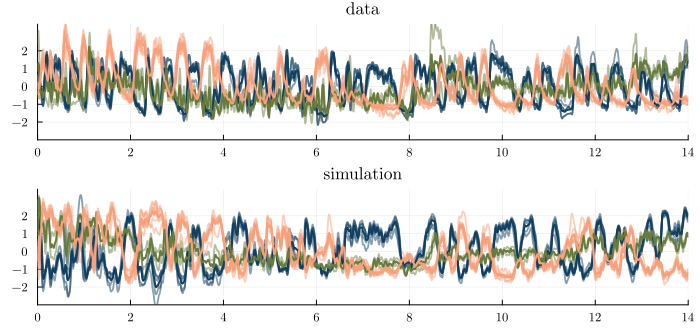

In [10]:
##############################
### Avg F and R clusters #####
##############################

F_id_range = 1:5    # ids for forward intrinsic neurons
avd_id_range = 6:7  # ids for avd intrinsic neurons
R_id_range = 8:15   # ids for reversal intrinsic neurons

avg_F_data = vec(mean(Dintrinsic[F_id_range,1:num_t],dims = 1))
avg_avd_data = vec(mean(Dintrinsic[avd_id_range,1:num_t],dims = 1))
avg_R_data = vec(mean(Dintrinsic[R_id_range,1:num_t],dims = 1))

avg_F_sim = vec(mean(sol_EJ_Syn[F_id_range,1:num_t],dims = 1))
avg_avd_sim = vec(mean(sol_EJ_Syn[avd_id_range,1:num_t],dims = 1))
avg_R_sim = vec(mean(sol_EJ_Syn[R_id_range,1:num_t],dims = 1))

##############################
##############################


######################################################
### Behavioral timeseries of data and simulation #####
######################################################
behav_ts = sign.(mean(Dintrinsic[F_id_range,1:num_t],dims = 1) - mean(Dintrinsic[R_id_range,1:num_t],dims = 1))
behav_ts_sim = sign.(mean(sol_EJ_Syn[F_id_range,1:num_t],dims = 1) - mean(sol_EJ_Syn[R_id_range,1:num_t],dims = 1))
######################################################
######################################################

########################
#### plot real TS ######
########################
p1 = plot(title = "data",ytick = -2:1:2, xlim = (0,14), ylim = (-3,3.5))
for i in 1:size(Dintrinsic,1)
    plot!(time_vec[1:num_t], Dintrinsic[i,1:num_t], label = false, color = clrs[i], linewidth = 1.8, alpha = 0.5) #label = intrinsic_neurons[i]
end

p1 = plot!(time_vec[1:num_t],avg_F_data, color = clrs[1], linewidth = 2) # plot avg of forward cluster
p1 = plot!(time_vec[1:num_t],avg_avd_data, color = clrs[6], linewidth = 2) # plot avg of avd cluster
p1 = plot!(time_vec[1:num_t],avg_R_data, color = clrs[8], linewidth = 2) # plot avg of reversal cluster

########################
#### plot simulation ######
########################
p2 = plot(title = "simulation",ytick = -2:1:2, xlim = (0,14), ylim = (-3,3.5))
for i in collect(1:Nintrinsic)
    plot!(sol_EJ_Syn.t,sol_EJ_Syn[i,:], label = false, color = clrs[i], linewidth = 1.8, alpha = 0.5)
end

p2 = plot!(time_vec[1:num_t],avg_F_sim, color = clrs[1], linewidth = 2) # plot avg of forward cluster
p2 = plot!(time_vec[1:num_t],avg_avd_sim, color = clrs[6], linewidth = 2) # plot avg of forward cluster
p2 = plot!(time_vec[1:num_t],avg_R_sim, color = clrs[8], linewidth = 2) # plot avg of reversal cluster

pall = plot(p1,p2, layout = (2,1), size = (700,330)) #size = (700,300)

display(pall)
# savefig(pall, path_and_name) # ava plot

#savefig(pall,"figures/new_figs/rev_figs/data_sim_2023-01-05-01.pdf")

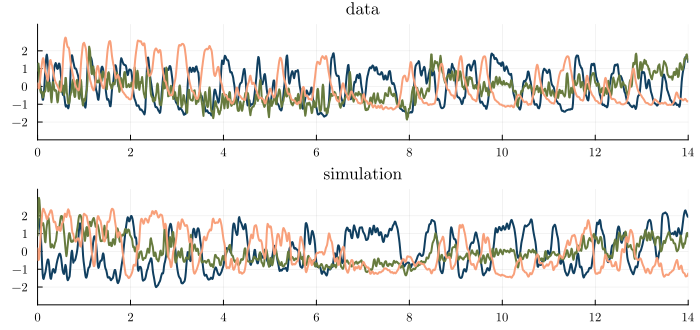

In [11]:
############################
#### plot real TS avg ######
############################
p1 = plot(title = "data",ytick = -2:1:2, xlim = (0,14), ylim = (-3,3.5))

p1 = plot!(time_vec[1:num_t],avg_F_data, color = clrs[1], linewidth = 2) # plot avg of forward cluster
p1 = plot!(time_vec[1:num_t],avg_avd_data, color = clrs[6], linewidth = 2) # plot avg of forward cluster
p1 = plot!(time_vec[1:num_t],avg_R_data, color = clrs[13], linewidth = 2) # plot avg of reversal cluster


##################################
#### plot simulation TS avg ######
##################################
p2 = plot(title = "simulation",ytick = -2:1:2, xlim = (0,14), ylim = (-3,3.5))
p2 = plot!(time_vec[1:num_t],avg_F_sim, color = clrs[1], linewidth = 2) # plot avg of forward cluster
p2 = plot!(time_vec[1:num_t],avg_avd_sim, color = clrs[6], linewidth = 2) # plot avg of forward cluster
p2 = plot!(time_vec[1:num_t],avg_R_sim, color = clrs[13], linewidth = 2) # plot avg of reversal cluster

pall = plot(p1,p2, layout = (2,1), size = (700,330)) #size = (700,300)

display(pall)

In [12]:
function behav_st(val)
    if val >= 0.5
        val_state = 1
    elseif val <= -0.5
        val_state = -1
    else
        val_state = 0
    end
return val_state
end

function velocity_st(val)
    if val >= 0.01
        val_state = 1
    elseif val <= -0.01
        val_state = -1
    else
        val_state = 0
    end
return val_state
end

velocity_st (generic function with 1 method)

In [13]:
function count_successive_repeats(arr)
    counts = []
    current_count = 1
    
    for i in 1:length(arr)-1
        if arr[i] == arr[i+1]
            current_count += 1
        else
            push!(counts, current_count)
            current_count = 1
        end
    end
    
    push!(counts, current_count)
    return counts
end

count_successive_repeats (generic function with 1 method)

## Do simulation with certain neurons cut out

## Knockout classes of core neurons -- see affect!

In [14]:
###########################
###### ODE function #######
###########################
function lorenz_chop!(du,u,p,t)
    γ, β, τ, cut_range = p
    #### get the current signal ####
    usig_tmp = []
    for j in collect(1:Nsignals)
        append!(usig_tmp,Dsigs_interp[j](t))
    end
    
    #### put both the intrinsic and signal into single vector ####
    utmp = zeros(Ncore)
    utmp[ids_intrinsic] = u  #put in current intrinsic timepoints
    utmp[ids_signal] = usig_tmp
    du_tmp = zeros(Ncore)
    ublockT = transpose(repeat(utmp, 1, Ncore))
    ublock = repeat(utmp, 1, Ncore)
    #A_u = A*u

    ######### cut out ablated neurons and connections W_cut and A_cut ######
    #cut_range = 1:2
    W[:,ids_intrinsic[cut_range]]
    W_cut = W[:,:]
    W_cut[:, ids_intrinsic[cut_range]] = 0*W_cut[:, ids_intrinsic[cut_range]]
    W_u = diag(W_cut*(ublock - ublockT))

    A_cut = A[:,:]
    A_cut[:, ids_intrinsic[cut_range]] = 0*A_cut[:, ids_intrinsic[cut_range]]
    A_RELUu = A_cut*Relu.(utmp) # use instead of A_u
   
    for j in collect(1:Ncore)
        ########### divide by global timescale variable tau ############
         du_tmp[j] = (1/τ)*(a*(utmp[j].-fp1).*(utmp[j].-fp2).*(utmp[j].-fp3) + d[j] + γ*A_RELUu[j] + β*W_u[j]) # fps version
    end
    
    du_tmp = du_tmp[ids_intrinsic]  # JUST output the derivative for the intrinsic neurons!
    for j in collect(1:Nintrinsic)
        #du[j] = -1*u[j] + Dsigs_interp[j](t)
        du[j] = du_tmp[j]
    end

    ##############  set du AVB vals to zero  #######
    du[cut_range] = 0*du[cut_range]

end

lorenz_chop! (generic function with 1 method)

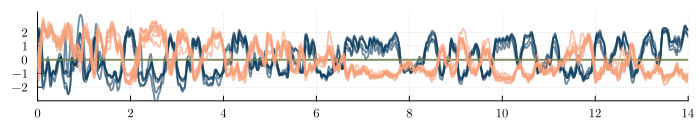

In [15]:
##########
#########
### Get signals ###
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]

#################
##############
Dsignals = 1*Dcore_cut[ids_signal,:]

################
Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition

###################
## SET AVB neurons to zero #######
###################

#cut_range = 1:2
cut_range = [6,7]
#cut_range = [8,9,10,11,12,13]


###############
##############
u0[cut_range] = 0*u0[cut_range]
#######################

num_steps = 1400
t_short = dt*collect(0:num_steps)
num_t = length(t_short)

####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end

tspan = (0.0,t_short[end])  # timespan for the ode

#######################################
## both synaptic and EJ connections ###
#######################################

p = (γ, β, τ, cut_range)
prob = ODEProblem(lorenz_chop!,u0,tspan, p)
sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);


###############
###  PLOT   ###
###############

##############################
### Avg F and R clusters #####
##############################
F_id_range = 1:5    # ids for forward intrinsic neurons
avd_id_range = 6:7  # ids for avd intrinsic neurons
R_id_range = 8:15   # ids for reversal intrinsic neurons

avg_F_sim = vec(mean(sol_EJ_Syn[F_id_range,1:num_t],dims = 1))
avg_avd_sim = vec(mean(sol_EJ_Syn[avd_id_range,1:num_t],dims = 1))
avg_R_sim = vec(mean(sol_EJ_Syn[R_id_range,1:num_t],dims = 1))
##############################
##############################

F_data_ts = mean(Dintrinsic[1:5,1:num_steps+1],dims = 1)
R_data_ts = mean(Dintrinsic[8:13,1:num_steps+1],dims = 1)


########################
#### plot simulation ######
########################
p2 = plot(ytick = -2:1:2, xlim = (0,14), ylim = (-3,3.5))  #ylim = (-3,3.5)

for i in collect(1:Nintrinsic)
    plot!(sol_EJ_Syn.t,sol_EJ_Syn[i,:], label = false, color = clrs[i], linewidth = 1.8, alpha = 0.6)
end

#p2 = plot!(time_vec[1:num_t],avg_F_sim, color = clrs[1], linewidth = 2) # , label = L"F(t)" # plot avg of forward cluster
#p2 = plot!(time_vec[1:num_t],avg_R_sim, color = clrs[8], linewidth = 2)  #label = L"R(t)" # plot avg of reversal cluster

p2 = plot!(size = (700,120)) # legend =:outerleft, #size = (700,300)
display(p2)



#savefig(p2,"figures/new_figs/core_set_to_zero_AVB.pdf")
#savefig(p2,"figures/new_figs/core_set_to_zero_RIB.pdf")
#avefig(p2,"figures/new_figs/core_set_to_zero_RID.pdf")

#savefig(p2,"figures/new_figs/core_set_to_zero_AVD.pdf")
#savefig(p2,"figures/new_figs/core_set_to_zero_AVA.pdf")
#savefig(p2,"figures/new_figs/core_set_to_zero_RIM.pdf")
#savefig(p2,"figures/new_figs/core_set_to_zero_AVE.pdf")

#savefig(p2,"figures/new_figs/core_set_to_zero_AIB.pdf")


######## final round #######
#savefig(p2,"figures/new_figs/core_set_to_zero_noablations.pdf")
#savefig(p2,"figures/new_figs/core_set_to_zero_AVA_AVD_AVE.pdf")

#savefig(p2,"figures/new_figs/core_set_to_zero_AIB.pdf")
#savefig(p2,"figures/new_figs/core_set_to_zero_RIB.pdf")
#savefig(p2,"figures/new_figs/core_set_to_zero_AVD.pdf")


In [16]:
core_neurons[ids_intrinsic]

15-element Vector{String7}:
 "AVBL"
 "AVBR"
 "RIBL"
 "RIBR"
 "RID"
 "AVDL"
 "AVDR"
 "AVAL"
 "AVAR"
 "RIML"
 "RIMR"
 "AVEL"
 "AVER"
 "AIBL"
 "AIBR"

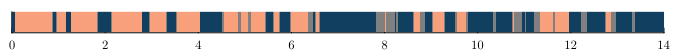

In [17]:
######################################################
### Behavioral timeseries of data and simulation #####
######################################################

thresh = 0.5

z_data_ts = F_data_ts - R_data_ts
z_data_ts[z_data_ts.> thresh] .= 1
z_data_ts[z_data_ts.< -thresh] .= -1
z_data_ts[(z_data_ts .> -thresh).*(z_data_ts .< thresh)] .=0
behav_ts = sign.(z_data_ts)

z_sim_ts = avg_F_sim - avg_R_sim
z_sim_ts[z_sim_ts .> thresh] .= 1
z_sim_ts[z_sim_ts .< -thresh] .= -1
z_sim_ts[(z_sim_ts .> -thresh).*(z_sim_ts .< thresh)] .=0
behav_ts_sim = sign.(z_sim_ts)

######################################################
######################################################

######### Make ambiguous regions grey ##########
c1 = palette(:batlow10)|> collect
c1 = c1[2:8]
c1[3] = :grey
c1[4] = :grey
c1[5] = :grey

behav_ts_sim = reshape(behav_ts_sim,1,:)

p2 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = c1, clim = (-1,1), 
        xticks=(0:2:14), ytick = false, legend=:none), size = (676,50))


display(p2)


#savefig(p2,"figures/new_figs/core_set_to_zero_noablations_behav.pdf")

#savefig(p2,"figures/new_figs/core_set_to_zero_AVA_AVD_AVE_behav.pdf")

#savefig(p2,"figures/new_figs/core_set_to_zero_AIB_behav.pdf")

#savefig(p2,"figures/new_figs/core_set_to_zero_RIB_behav.pdf")

#savefig(p2,"figures/new_figs/core_set_to_zero_AVD_behav.pdf")


## No core ablation

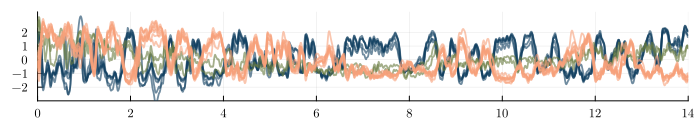

In [18]:
##########
#########
### Get signals ###
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]

#################
##############
Dsignals = 1*Dcore_cut[ids_signal,:]

################
Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition

###################
## SET AVB neurons to zero #######
###################

#cut_range = 1:2
#cut_range = [6,7]
#cut_range = [8,9,10,11,12,13]


###############
##############
#u0[cut_range] = 0*u0[cut_range]
#######################

num_steps = 1400
t_short = dt*collect(0:num_steps)
num_t = length(t_short)

####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end

tspan = (0.0,t_short[end])  # timespan for the ode

#######################################
## both synaptic and EJ connections ###
#######################################

p = (γ, β, τ, cut_range)
prob = ODEProblem(lorenz!,u0,tspan, p)
sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);


###############
###  PLOT   ###
###############

##############################
### Avg F and R clusters #####
##############################
F_id_range = 1:5    # ids for forward intrinsic neurons
avd_id_range = 6:7  # ids for avd intrinsic neurons
R_id_range = 8:15   # ids for reversal intrinsic neurons

avg_F_sim = vec(mean(sol_EJ_Syn[F_id_range,1:num_t],dims = 1))
avg_avd_sim = vec(mean(sol_EJ_Syn[avd_id_range,1:num_t],dims = 1))
avg_R_sim = vec(mean(sol_EJ_Syn[R_id_range,1:num_t],dims = 1))
##############################
##############################

F_data_ts = mean(Dintrinsic[1:5,1:num_steps+1],dims = 1)
R_data_ts = mean(Dintrinsic[8:13,1:num_steps+1],dims = 1)


########################
#### plot simulation ######
########################
p2 = plot(ytick = -2:1:2, xlim = (0,14), ylim = (-3,3.5))  #ylim = (-3,3.5)

for i in collect(1:Nintrinsic)
    plot!(sol_EJ_Syn.t,sol_EJ_Syn[i,:], label = false, color = clrs[i], linewidth = 1.8, alpha = 0.6)
end

#p2 = plot!(time_vec[1:num_t],avg_F_sim, color = clrs[1], linewidth = 2) # , label = L"F(t)" # plot avg of forward cluster
#p2 = plot!(time_vec[1:num_t],avg_R_sim, color = clrs[8], linewidth = 2)  #label = L"R(t)" # plot avg of reversal cluster

p2 = plot!(size = (700,120)) # legend =:outerleft, #size = (700,300)
display(p2)


######## final round #######
#savefig(p2,"figures/core_ablations/core_set_to_zero_noablations.pdf")


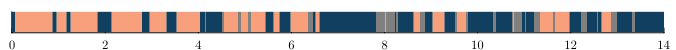

In [19]:
######################################################
### Behavioral timeseries of data and simulation #####
######################################################

thresh = 0.5

z_data_ts = F_data_ts - R_data_ts
z_data_ts[z_data_ts.> thresh] .= 1
z_data_ts[z_data_ts.< -thresh] .= -1
z_data_ts[(z_data_ts .> -thresh).*(z_data_ts .< thresh)] .=0
behav_ts = sign.(z_data_ts)

z_sim_ts = avg_F_sim - avg_R_sim
z_sim_ts[z_sim_ts .> thresh] .= 1
z_sim_ts[z_sim_ts .< -thresh] .= -1
z_sim_ts[(z_sim_ts .> -thresh).*(z_sim_ts .< thresh)] .=0
behav_ts_sim = sign.(z_sim_ts)

######################################################
######################################################

######### Make ambiguous regions grey ##########
c1 = palette(:batlow10)|> collect
c1 = c1[2:8]
c1[3] = :grey
c1[4] = :grey
c1[5] = :grey

behav_ts_sim = reshape(behav_ts_sim,1,:)

p2 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = c1, clim = (-1,1), 
        xticks=(0:2:14), ytick = false, legend=:none), size = (676,50))

display(p2)

#savefig(p2,"figures/core_ablations/core_set_to_zero_noablations_behav.pdf")





In [20]:
##  what is the threshold?
##  5 seconds -> 0.0833 minutes, 

num_steps_pause_cut = Int(round((5/60)/dt))  # 5 seconds, convert to min, divide by time step
num_steps_FR_cut = Int(round((2/60)/dt))


#######################################
####  take out short F/R, < 2 sec, set to pause state #####
#######################################
for i in num_steps_FR_cut+1:length(behav_ts_sim)-1
    if (behav_ts_sim[i] != 0) & (behav_ts_sim[i+1] == 0)
        p_hist = sum(abs.(behav_ts_sim[i-num_steps_FR_cut:i] .==0))

        if p_hist !=0
            id_switch = findlast(item -> item != 0, diff(behav_ts_sim[i-num_steps_FR_cut:i])) 
            behav_ts_sim[i-num_steps_FR_cut+id_switch:i] .= behav_ts_sim[i+1]
        end
    end
end


#######################################
## take out short pauses, < 5 sec #####
#######################################
for i in num_steps_pause_cut+1:length(behav_ts_sim)-1
    if (behav_ts_sim[i] == 0) & (behav_ts_sim[i+1] != 0)
        p_hist = sum(abs.(behav_ts_sim[i-num_steps_pause_cut:i]))

        if p_hist !=0
            id_switch = findlast(item -> item != 0, diff(behav_ts_sim[i-num_steps_pause_cut:i])) 

            if behav_ts_sim[i-num_steps_pause_cut+id_switch-1] == behav_ts_sim[i+1]
                behav_ts_sim[i-num_steps_pause_cut+id_switch:i] .= behav_ts_sim[i+1]
            end
        end
    end
end


# Figure 6

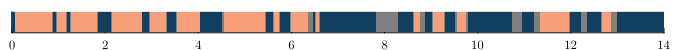

per F = 0.455
per R = 0.416
per P = 0.129


In [21]:
p2 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = c1, clim = (-1,1), 
        xticks=(0:2:14), ytick = false, legend=:none), size = (676,50))


display(p2)

#savefig(p2,"figures/core_ablations/core_set_to_zero_noablations_behav_cleaned.pdf")

#####################################################################
#### compute percentage of time in Forward and Reversal states  #####
#####################################################################

num_F = sum(behav_ts_sim .== 1)
num_R = sum(behav_ts_sim .== -1)
num_P = sum(behav_ts_sim .== 0)
tot = num_F + num_R + num_P

per_F = round(num_F/tot, digits = 3)
per_R = round(num_R/tot, digits = 3)
per_P = round(num_P/tot, digits = 3)


println("per F = ", per_F)
println("per R = ", per_R)
println("per P = ", per_P)


### Summary stats, no ablation

In [22]:
F_ts = vec(behav_ts_sim .== 1)
R_ts = vec(behav_ts_sim .== -1)

## Forward ##
F_diffs = diff(F_ts)
idx_tmp = findall(!=(0), F_diffs)

F_durs = []
dur_tmp = sum(F_ts[1:idx_tmp[1]])
if dur_tmp !=0
    push!(F_durs, dur_tmp)
end

for i in 1:length(idx_tmp)-1
    dur_tmp = sum(F_ts[idx_tmp[i]+1:idx_tmp[i+1]])

    if dur_tmp !=0
        push!(F_durs, dur_tmp)
    end
end

## Reversal ##
R_diffs = diff(R_ts)
idx_tmp = findall(!=(0), R_diffs)

R_durs = []
dur_tmp = sum(R_ts[1:idx_tmp[1]])
if dur_tmp !=0
    push!(R_durs, dur_tmp)
end


for i in 1:length(idx_tmp)-1
    dur_tmp = sum(R_ts[idx_tmp[i]+1:idx_tmp[i+1]])

    if dur_tmp !=0
        push!(R_durs, dur_tmp)
    end
end

println("avg F duration= ", round(dt*mean(F_durs), digits = 3))
println("avg R duration= ", round(dt*mean(R_durs), digits = 3))

println("num Rs = ", length(R_durs))

avg F duration= 0.297
avg R duration= 0.389
num Rs = 15


## Core ablate RIB

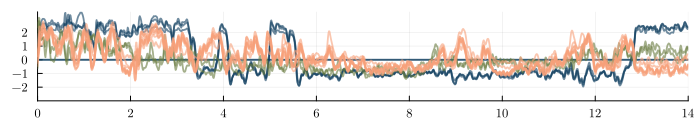

In [23]:
##########
#########
### Get signals ###
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]

#################
##############
Dsignals = 1*Dcore_cut[ids_signal,:]

################
Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition

###################
## SET RIB neurons to zero #######
###################

#cut_range = 1:2
cut_range = [3,4]
#cut_range = [8,9,10,11,12,13]


###############
##############
u0[cut_range] = 0*u0[cut_range]
#######################

num_steps = 1400
t_short = dt*collect(0:num_steps)
num_t = length(t_short)

####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end

tspan = (0.0,t_short[end])  # timespan for the ode

#######################################
## both synaptic and EJ connections ###
#######################################

p = (γ, β, τ, cut_range)
prob = ODEProblem(lorenz_chop!,u0,tspan, p)
sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);


###############
###  PLOT   ###
###############

##############################
### Avg F and R clusters #####
##############################
F_id_range = 1:5    # ids for forward intrinsic neurons
avd_id_range = 6:7  # ids for avd intrinsic neurons
R_id_range = 8:15   # ids for reversal intrinsic neurons

avg_F_sim = vec(mean(sol_EJ_Syn[F_id_range,1:num_t],dims = 1))
avg_avd_sim = vec(mean(sol_EJ_Syn[avd_id_range,1:num_t],dims = 1))
avg_R_sim = vec(mean(sol_EJ_Syn[R_id_range,1:num_t],dims = 1))
##############################
##############################

F_data_ts = mean(Dintrinsic[1:5,1:num_steps+1],dims = 1)
R_data_ts = mean(Dintrinsic[8:13,1:num_steps+1],dims = 1)


########################
#### plot simulation ######
########################
p2 = plot(ytick = -2:1:2, xlim = (0,14), ylim = (-3,3.5))  #ylim = (-3,3.5)

for i in collect(1:Nintrinsic)
    plot!(sol_EJ_Syn.t,sol_EJ_Syn[i,:], label = false, color = clrs[i], linewidth = 1.8, alpha = 0.6)
end

#p2 = plot!(time_vec[1:num_t],avg_F_sim, color = clrs[1], linewidth = 2) # , label = L"F(t)" # plot avg of forward cluster
#p2 = plot!(time_vec[1:num_t],avg_R_sim, color = clrs[8], linewidth = 2)  #label = L"R(t)" # plot avg of reversal cluster

p2 = plot!(size = (700,120)) # legend =:outerleft, #size = (700,300)
display(p2)


######## final round #######

#savefig(p2,"figures/core_ablations/core_set_to_zero_RIB.pdf")


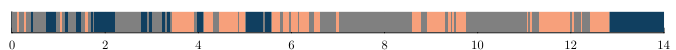

In [24]:
######################################################
### Behavioral timeseries of data and simulation #####
######################################################

thresh = 0.5

z_data_ts = F_data_ts - R_data_ts
z_data_ts[z_data_ts.> thresh] .= 1
z_data_ts[z_data_ts.< -thresh] .= -1
z_data_ts[(z_data_ts .> -thresh).*(z_data_ts .< thresh)] .=0
behav_ts = sign.(z_data_ts)

z_sim_ts = avg_F_sim - avg_R_sim
z_sim_ts[z_sim_ts .> thresh] .= 1
z_sim_ts[z_sim_ts .< -thresh] .= -1
z_sim_ts[(z_sim_ts .> -thresh).*(z_sim_ts .< thresh)] .=0
behav_ts_sim = sign.(z_sim_ts)

######################################################
######################################################

######### Make ambiguous regions grey ##########
c1 = palette(:batlow10)|> collect
c1 = c1[2:8]
c1[3] = :grey
c1[4] = :grey
c1[5] = :grey

behav_ts_sim = reshape(behav_ts_sim,1,:)

p2 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = c1, clim = (-1,1), 
        xticks=(0:2:14), ytick = false, legend=:none), size = (676,50))

display(p2)

#savefig(p2,"figures/core_ablations/core_set_to_zero_RIB_behav.pdf")

In [25]:
##  what is the threshold?
## 5 seconds -> 0.0833 minutes, 

num_steps_pause_cut = Int(round((5/60)/dt))  # 5 seconds, convert to min, divide by time step
num_steps_FR_cut = Int(round((2/60)/dt))



#######################################
####  take out short F/R, < 2 sec, set to pause state #####
#######################################
for i in num_steps_FR_cut+1:length(behav_ts_sim)-1
    if (behav_ts_sim[i] != 0) & (behav_ts_sim[i+1] == 0)
        p_hist = sum(abs.(behav_ts_sim[i-num_steps_FR_cut:i] .==0))

        if p_hist !=0
            id_switch = findlast(item -> item != 0, diff(behav_ts_sim[i-num_steps_FR_cut:i])) 
            behav_ts_sim[i-num_steps_FR_cut+id_switch:i] .= behav_ts_sim[i+1]

        end
    end
end


#######################################
## take out short pauses, < 5 sec #####
#######################################
for i in num_steps_pause_cut+1:length(behav_ts_sim)-1
    if (behav_ts_sim[i] == 0) & (behav_ts_sim[i+1] != 0)
        p_hist = sum(abs.(behav_ts_sim[i-num_steps_pause_cut:i]))

        if p_hist !=0
            id_switch = findlast(item -> item != 0, diff(behav_ts_sim[i-num_steps_pause_cut:i])) 

            if behav_ts_sim[i-num_steps_pause_cut+id_switch-1] == behav_ts_sim[i+1]
                behav_ts_sim[i-num_steps_pause_cut+id_switch:i] .= behav_ts_sim[i+1]
            end
        end
    end
end



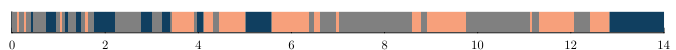

per F = 0.225
per R = 0.333
per P = 0.443


In [26]:
p2 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = c1, clim = (-1,1), 
        xticks=(0:2:14), ytick = false, legend=:none), size = (676,50))


display(p2)

#savefig(p2,"figures/core_ablations/core_set_to_zero_RIB_behav_cleaned.pdf")

#####################################################################
#### compute percentage of time in Forward and Reversal states  #####
#####################################################################

num_F = sum(behav_ts_sim .== 1)
num_R = sum(behav_ts_sim .== -1)
num_P = sum(behav_ts_sim .== 0)
tot = num_F + num_R + num_P

per_F = round(num_F/tot, digits = 3)
per_R = round(num_R/tot, digits = 3)
per_P = round(num_P/tot, digits = 3)


println("per F = ", per_F)
println("per R = ", per_R)
println("per P = ", per_P)

### summary stats, RIB ablation

In [27]:
F_ts = vec(behav_ts_sim .== 1)
R_ts = vec(behav_ts_sim .== -1)

## Forward ##
F_diffs = diff(F_ts)
idx_tmp = findall(!=(0), F_diffs)

F_durs = []
dur_tmp = sum(F_ts[1:idx_tmp[1]])
if dur_tmp !=0
    push!(F_durs, dur_tmp)
end

for i in 1:length(idx_tmp)-1
    dur_tmp = sum(F_ts[idx_tmp[i]+1:idx_tmp[i+1]])

    if dur_tmp !=0
        push!(F_durs, dur_tmp)
    end
end

## Reversal ##
R_diffs = diff(R_ts)
idx_tmp = findall(!=(0), R_diffs)

R_durs = []
dur_tmp = sum(R_ts[1:idx_tmp[1]])
if dur_tmp !=0
    push!(R_durs, dur_tmp)
end


for i in 1:length(idx_tmp)-1
    dur_tmp = sum(R_ts[idx_tmp[i]+1:idx_tmp[i+1]])

    if dur_tmp !=0
        push!(R_durs, dur_tmp)
    end
end

println("avg F duration= ", dt*mean(F_durs))
println("avg R duration= ", dt*mean(R_durs))

println("num Rs = ", length(R_durs))

avg F duration= 0.198
avg R duration= 0.31066666666666665
num Rs = 15


## Core ablate AIB

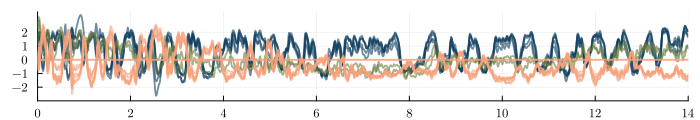

In [28]:
##########
#########
### Get signals ###
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]

#################
##############
Dsignals = 1*Dcore_cut[ids_signal,:]

################
Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition

###################
## SET AIB neurons to zero #######
###################
cut_range = [14,15]

###############
##############
u0[cut_range] = 0*u0[cut_range]
#######################

num_steps = 1400
t_short = dt*collect(0:num_steps)
num_t = length(t_short)

####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end

tspan = (0.0,t_short[end])  # timespan for the ode

#######################################
## both synaptic and EJ connections ###
#######################################

p = (γ, β, τ, cut_range)
prob = ODEProblem(lorenz_chop!,u0,tspan, p)
sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);


###############
###  PLOT   ###
###############

##############################
### Avg F and R clusters #####
##############################
F_id_range = 1:5    # ids for forward intrinsic neurons
avd_id_range = 6:7  # ids for avd intrinsic neurons
R_id_range = 8:15   # ids for reversal intrinsic neurons

avg_F_sim = vec(mean(sol_EJ_Syn[F_id_range,1:num_t],dims = 1))
avg_avd_sim = vec(mean(sol_EJ_Syn[avd_id_range,1:num_t],dims = 1))
avg_R_sim = vec(mean(sol_EJ_Syn[R_id_range,1:num_t],dims = 1))
##############################
##############################

F_data_ts = mean(Dintrinsic[1:5,1:num_steps+1],dims = 1)
R_data_ts = mean(Dintrinsic[8:13,1:num_steps+1],dims = 1)


########################
#### plot simulation ######
########################
p2 = plot(ytick = -2:1:2, xlim = (0,14), ylim = (-3,3.5))  #ylim = (-3,3.5)

for i in collect(1:Nintrinsic)
    plot!(sol_EJ_Syn.t,sol_EJ_Syn[i,:], label = false, color = clrs[i], linewidth = 1.8, alpha = 0.6)
end

#p2 = plot!(time_vec[1:num_t],avg_F_sim, color = clrs[1], linewidth = 2) # , label = L"F(t)" # plot avg of forward cluster
#p2 = plot!(time_vec[1:num_t],avg_R_sim, color = clrs[8], linewidth = 2)  #label = L"R(t)" # plot avg of reversal cluster

p2 = plot!(size = (700,120)) # legend =:outerleft, #size = (700,300)
display(p2)


######## final round #######

#savefig(p2,"figures/core_ablations/core_set_to_zero_AIB.pdf")

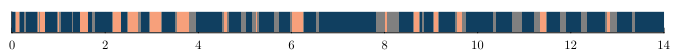

In [29]:
######################################################
### Behavioral timeseries of data and simulation #####
######################################################

thresh = 0.5

z_data_ts = F_data_ts - R_data_ts
z_data_ts[z_data_ts.> thresh] .= 1
z_data_ts[z_data_ts.< -thresh] .= -1
z_data_ts[(z_data_ts .> -thresh).*(z_data_ts .< thresh)] .=0
behav_ts = sign.(z_data_ts)

z_sim_ts = avg_F_sim - avg_R_sim
z_sim_ts[z_sim_ts .> thresh] .= 1
z_sim_ts[z_sim_ts .< -thresh] .= -1
z_sim_ts[(z_sim_ts .> -thresh).*(z_sim_ts .< thresh)] .=0
behav_ts_sim = sign.(z_sim_ts)

######################################################
######################################################

######### Make ambiguous regions grey ##########
c1 = palette(:batlow10)|> collect
c1 = c1[2:8]
c1[3] = :grey
c1[4] = :grey
c1[5] = :grey

behav_ts_sim = reshape(behav_ts_sim,1,:)

p2 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = c1, clim = (-1,1), 
        xticks=(0:2:14), ytick = false, legend=:none), size = (676,50))


display(p2)

#savefig(p2,"figures/core_ablations/core_set_to_zero_AIB_behav.pdf")

In [30]:
##  what is the threshold?
## 5 seconds -> 0.0833 minutes, 

num_steps_pause_cut = Int(round((5/60)/dt))  # 5 seconds, convert to min, divide by time step
num_steps_FR_cut = Int(round((2/60)/dt))


#######################################
####  take out short F/R, < 2 sec, set to pause state #####
#######################################
for i in num_steps_FR_cut+1:length(behav_ts_sim)-1
    if (behav_ts_sim[i] != 0) & (behav_ts_sim[i+1] == 0)
        p_hist = sum(abs.(behav_ts_sim[i-num_steps_FR_cut:i] .==0))

        if p_hist !=0

            id_switch = findlast(item -> item != 0, diff(behav_ts_sim[i-num_steps_FR_cut:i])) 
            behav_ts_sim[i-num_steps_FR_cut+id_switch:i] .= behav_ts_sim[i+1]


            #behav_ts_sim[i-num_steps_FR_cut:i] .= behav_ts_sim[i+1]
        end
    end
end


#######################################
## take out short pauses, < 5 sec #####
#######################################
for i in num_steps_pause_cut+1:length(behav_ts_sim)-1
    if (behav_ts_sim[i] == 0) & (behav_ts_sim[i+1] != 0)
        p_hist = sum(abs.(behav_ts_sim[i-num_steps_pause_cut:i]))

        if p_hist !=0
            id_switch = findlast(item -> item != 0, diff(behav_ts_sim[i-num_steps_pause_cut:i])) 

            if behav_ts_sim[i-num_steps_pause_cut+id_switch-1] == behav_ts_sim[i+1]
                behav_ts_sim[i-num_steps_pause_cut+id_switch:i] .= behav_ts_sim[i+1]
            end
        end
    end
end



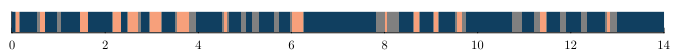

In [31]:
p2 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = c1, clim = (-1,1), 
        xticks=(0:2:14), ytick = false, legend=:none), size = (676,50))


display(p2)

#savefig(p2,"figures/core_ablations/core_set_to_zero_AIB_behav_cleaned.pdf")

### summary, AIB ablation

In [32]:
F_ts = vec(behav_ts_sim .== 1)
R_ts = vec(behav_ts_sim .== -1)

## Forward ##
F_diffs = diff(F_ts)
idx_tmp = findall(!=(0), F_diffs)

F_durs = []
dur_tmp = sum(F_ts[1:idx_tmp[1]])
if dur_tmp !=0
    push!(F_durs, dur_tmp)
end

for i in 1:length(idx_tmp)-1
    dur_tmp = sum(F_ts[idx_tmp[i]+1:idx_tmp[i+1]])

    if dur_tmp !=0
        push!(F_durs, dur_tmp)
    end
end

## Reversal ##
R_diffs = diff(R_ts)
idx_tmp = findall(!=(0), R_diffs)

R_durs = []
dur_tmp = sum(R_ts[1:idx_tmp[1]])
if dur_tmp !=0
    push!(R_durs, dur_tmp)
end


for i in 1:length(idx_tmp)-1
    dur_tmp = sum(R_ts[idx_tmp[i]+1:idx_tmp[i+1]])

    if dur_tmp !=0
        push!(R_durs, dur_tmp)
    end
end

println("avg F duration= ", round(dt*mean(F_durs), digits = 3))
println("avg R duration= ", round(dt*mean(R_durs), digits = 3))

println("num Rs = ", length(R_durs))

avg F duration= 0.382
avg R duration= 0.135
num Rs = 15


## Core ablate AVD, AVA, AVE

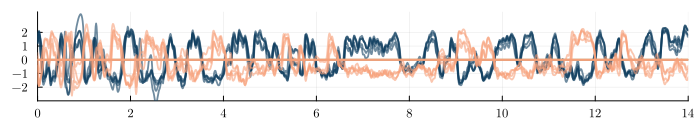

In [33]:
##########
#########
### Get signals ###
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]

#################
##############
Dsignals = 1*Dcore_cut[ids_signal,:]

################
Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition

###################
## SET AVD, AVA, AVE neurons to zero #######
###################
cut_range = [6,7,8,9,12,13]

###############
##############
u0[cut_range] = 0*u0[cut_range]
#######################

num_steps = 1400
t_short = dt*collect(0:num_steps)
num_t = length(t_short)

####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end

tspan = (0.0,t_short[end])  # timespan for the ode

#######################################
## both synaptic and EJ connections ###
#######################################

p = (γ, β, τ, cut_range)
prob = ODEProblem(lorenz_chop!,u0,tspan, p)
sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);


###############
###  PLOT   ###
###############

##############################
### Avg F and R clusters #####
##############################
F_id_range = 1:5    # ids for forward intrinsic neurons
avd_id_range = 6:7  # ids for avd intrinsic neurons
R_id_range = 8:15   # ids for reversal intrinsic neurons

avg_F_sim = vec(mean(sol_EJ_Syn[F_id_range,1:num_t],dims = 1))
avg_avd_sim = vec(mean(sol_EJ_Syn[avd_id_range,1:num_t],dims = 1))
avg_R_sim = vec(mean(sol_EJ_Syn[R_id_range,1:num_t],dims = 1))
##############################
##############################

F_data_ts = mean(Dintrinsic[1:5,1:num_steps+1],dims = 1)
R_data_ts = mean(Dintrinsic[8:13,1:num_steps+1],dims = 1)


########################
#### plot simulation ######
########################
p2 = plot(ytick = -2:1:2, xlim = (0,14), ylim = (-3,3.5))  #ylim = (-3,3.5)

for i in collect(1:Nintrinsic)
    plot!(sol_EJ_Syn.t,sol_EJ_Syn[i,:], label = false, color = clrs[i], linewidth = 1.8, alpha = 0.6)
end

#p2 = plot!(time_vec[1:num_t],avg_F_sim, color = clrs[1], linewidth = 2) # , label = L"F(t)" # plot avg of forward cluster
#p2 = plot!(time_vec[1:num_t],avg_R_sim, color = clrs[8], linewidth = 2)  #label = L"R(t)" # plot avg of reversal cluster

p2 = plot!(size = (700,120)) # legend =:outerleft, #size = (700,300)
display(p2)


######## final round #######

#savefig(p2,"figures/core_ablations/core_set_to_zero_AVA_AVD_AVE.pdf")

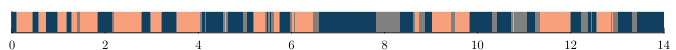

In [34]:
######################################################
### Behavioral timeseries of data and simulation #####
######################################################

thresh = 0.5

z_data_ts = F_data_ts - R_data_ts
z_data_ts[z_data_ts.> thresh] .= 1
z_data_ts[z_data_ts.< -thresh] .= -1
z_data_ts[(z_data_ts .> -thresh).*(z_data_ts .< thresh)] .=0
behav_ts = sign.(z_data_ts)

z_sim_ts = avg_F_sim - avg_R_sim
z_sim_ts[z_sim_ts .> thresh] .= 1
z_sim_ts[z_sim_ts .< -thresh] .= -1
z_sim_ts[(z_sim_ts .> -thresh).*(z_sim_ts .< thresh)] .=0
behav_ts_sim = sign.(z_sim_ts)

######################################################
######################################################

######### Make ambiguous regions grey ##########
c1 = palette(:batlow10)|> collect
c1 = c1[2:8]
c1[3] = :grey
c1[4] = :grey
c1[5] = :grey

behav_ts_sim = reshape(behav_ts_sim,1,:)

p2 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = c1, clim = (-1,1), 
        xticks=(0:2:14), ytick = false, legend=:none), size = (676,50))


display(p2)

#savefig(p2,"figures/core_ablations/core_set_to_zero_AVA_AVD_AVE_behav.pdf")

In [35]:
##  what is the threshold?
## 5 seconds -> 0.0833 minutes, 

num_steps_pause_cut = Int(round((5/60)/dt))  # 5 seconds, convert to min, divide by time step
num_steps_FR_cut = Int(round((2/60)/dt))


#######################################
####  take out short F/R, < 2 sec, set to pause state #####
#######################################
for i in num_steps_FR_cut+1:length(behav_ts_sim)-1
    if (behav_ts_sim[i] != 0) & (behav_ts_sim[i+1] == 0)
        p_hist = sum(abs.(behav_ts_sim[i-num_steps_FR_cut:i] .==0))

        if p_hist !=0
            id_switch = findlast(item -> item != 0, diff(behav_ts_sim[i-num_steps_FR_cut:i])) 
            behav_ts_sim[i-num_steps_FR_cut+id_switch:i] .= behav_ts_sim[i+1]

        end
    end
end


#######################################
## take out short pauses, < 5 sec #####
#######################################
for i in num_steps_pause_cut+1:length(behav_ts_sim)-1
    if (behav_ts_sim[i] == 0) & (behav_ts_sim[i+1] != 0)
        p_hist = sum(abs.(behav_ts_sim[i-num_steps_pause_cut:i]))

        if p_hist !=0
            id_switch = findlast(item -> item != 0, diff(behav_ts_sim[i-num_steps_pause_cut:i])) 

            if behav_ts_sim[i-num_steps_pause_cut+id_switch-1] == behav_ts_sim[i+1]
                behav_ts_sim[i-num_steps_pause_cut+id_switch:i] .= behav_ts_sim[i+1]
            end
        end
    end
end



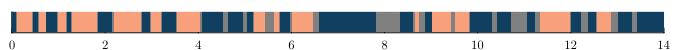

In [36]:
p2 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = c1, clim = (-1,1), 
        xticks=(0:2:14), ytick = false, legend=:none), size = (676,50))

display(p2)

#savefig(p2,"figures/core_ablations/core_set_to_zero_AVA_AVD_AVE_behav_cleaned.pdf")

## summary, AVD, AVA, AVE ablation

In [37]:
F_ts = vec(behav_ts_sim .== 1)
R_ts = vec(behav_ts_sim .== -1)

## Forward ##
F_diffs = diff(F_ts)
idx_tmp = findall(!=(0), F_diffs)

F_durs = []
dur_tmp = sum(F_ts[1:idx_tmp[1]])
if dur_tmp !=0
    push!(F_durs, dur_tmp)
end

for i in 1:length(idx_tmp)-1
    dur_tmp = sum(F_ts[idx_tmp[i]+1:idx_tmp[i+1]])

    if dur_tmp !=0
        push!(F_durs, dur_tmp)
    end
end

## Reversal ##
R_diffs = diff(R_ts)
idx_tmp = findall(!=(0), R_diffs)

R_durs = []
dur_tmp = sum(R_ts[1:idx_tmp[1]])
if dur_tmp !=0
    push!(R_durs, dur_tmp)
end


for i in 1:length(idx_tmp)-1
    dur_tmp = sum(R_ts[idx_tmp[i]+1:idx_tmp[i+1]])

    if dur_tmp !=0
        push!(R_durs, dur_tmp)
    end
end

println("avg F duration= ", dt*mean(F_durs))
println("avg R duration= ", dt*mean(R_durs))

println("num Rs = ", length(R_durs))

avg F duration= 0.28550000000000003
avg R duration= 0.32866666666666666
num Rs = 15
